In [1]:
# import lib
from __future__ import print_function
import numpy as np 
import math
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# data processing
%run 'dataprocessing.ipynb'
print ("number of training examples = " + str(train_images.shape[0]))
print ("number of test examples = " + str(test_images.shape[0]))
print ("X_train shape: " + str(train_images.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(test_images.shape))
print ("Y_test shape: " + str(test_labels.shape))

Loading training set
Done
Loading test set
Done
Normalization
Done
Converting to one-hot code
Done
Finished!
number of training examples = 28736
number of test examples = 9673
X_train shape: (28736, 100, 100, 3)
Y_train shape: (28736, 60)
X_test shape: (9673, 100, 100, 3)
Y_test shape: (9673, 60)


In [3]:
# create placeholder for x and y
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    
    return X, Y

x, y = create_placeholders(100, 100, 3, 60)
print ("x = " + str(x))
print ("y = " + str(y))

x = Tensor("Placeholder:0", shape=(?, 100, 100, 3), dtype=float32)
y = Tensor("Placeholder_1:0", shape=(?, 60), dtype=float32)


In [4]:
# initialize parameters

def initialize_parameters():
    
    tf.set_random_seed(1)
    
    w1_shape = [3,3,3,16]
    w2_shape = [3,3,16,32]
    w3_shape = [3,3,32,32]
    w4_shape = [3,3,32,64]
    
    w1 = tf.get_variable('w1', w1_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    w2 = tf.get_variable('w2', w2_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    w3 = tf.get_variable('w3', w3_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    w4 = tf.get_variable('w4', w4_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {'w1': w1, 'w2': w2, 'w3': w3, 'w4': w4}
    
    return parameters

In [25]:
# forward_propagation

def forward_propagation(x, parameters, prob):
    # retrieve weights
    w1 = parameters['w1']
    w2 = parameters['w2']
    w3 = parameters['w3']
    w4 = parameters['w4']
    
    # conv1: k = (3,3), input = (100,100,3), output = 16, padding=0, stride =1
    x = tf.nn.conv2d(x, w1, strides = [1, 1, 1, 1], padding = 'SAME')
    # batchnormalization
    x = tf.layers.batch_normalization(x)
    # relu
    x = tf.nn.leaky_relu(x, alpha=0.5)
    # maxpool: (2,2), stride = 2, padding = 0
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

    
    # conv2: k = (3,3), input = 16, output = 32
    x = tf.nn.conv2d(x, w2, strides = [1,1,1,1], padding = 'SAME')
    # batchnormalization
    x = tf.layers.batch_normalization(x)
    # relu
    x = tf.nn.leaky_relu(x, alpha=0.5)
    # maxpool: (2,2)
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # conv3
    x = tf.nn.conv2d(x, w3, strides = [1,1,1,1], padding = 'SAME')
    # batchnormalization
    x = tf.layers.batch_normalization(x)
    # relu
    x = tf.nn.leaky_relu(x, alpha=0.5)
    # maxpool: (2,2)
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # conv4
    x = tf.nn.conv2d(x, w4, strides = [1,1,1,1], padding = 'SAME')
    # batchnormalization
    x = tf.layers.batch_normalization(x)
    # relu
    x = tf.nn.leaky_relu(x, alpha=0.5)
    # maxpool: (2,2)
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
          
    # flatten
    x = tf.contrib.layers.flatten(x)
    
    # fully-connected 
    # dense1
    x = tf.contrib.layers.fully_connected(x, 256, activation_fn = tf.nn.relu)
    # dropout
    x = tf.nn.dropout(x, keep_prob=prob)
    
    # dense2
    y = tf.contrib.layers.fully_connected(x, 60, activation_fn = None)
    
    return y
    

In [31]:
# compute cost
def compute_cost(y_pred, y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred, labels = y)) 
    return cost

def compute_accuracy(y_pred, x, y, size, x_, y_, prob, dropout):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(y_pred),1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    num = int(x_.shape[0]/size)
    acc_ = 0
    for i in range(num):
        acc = accuracy.eval({x:x_[i*size:(i+1)*size], y:y_[i*size:(i+1)*size], prob:dropout})
        acc_ += acc/num

    return acc_



In [45]:
# training
def training(xtrain, ytrain, xtest, ytest, alpha = 0.001, epochs = 20, minibatch_size = 128, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    (m, n_H0, n_W0, n_C0) = xtrain.shape
    n_y = ytrain.shape[1]
    costs = []
    costs_test = []
    accs_train = []
    accs_test = []
    minibatch_num = int(m/minibatch_size)
    
    x,y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    prob = tf.placeholder_with_default(1.0, shape=())
    
    # initialize
    parameters = initialize_parameters()
    
    # forwardprop
    y_pred = forward_propagation(x, parameters, prob)
    
    # cost function
    cost = compute_cost(y_pred, y)
    
    # backprop
    optimizer = tf.train.AdamOptimizer(alpha).minimize(cost)
       
    # initialize
    init = tf.global_variables_initializer()
    init2 = tf.local_variables_initializer()
    
     
    
    # session
    with tf.Session() as sess:
        sess.run(init)
        sess.run(init2)
                    
        # training
        for epo in range(epochs):
            tf.set_random_seed(1)
            minibatch_cost = 0
            cost_test = 0
            
            # shuffle
            minibatch = np.random.choice(np.random.permutation(m), 
                                         minibatch_size * minibatch_num).reshape(minibatch_num, minibatch_size)
            minibatch_index = np.random.permutation(minibatch_num)  
                       
            for mb in range(minibatch_num):
                i = minibatch_index[mb]
                indx = minibatch[i]
                inputs = xtrain[indx]
                labels = ytrain[indx]

                # feed the inputs
                _, temp_cost = sess.run([optimizer, cost], feed_dict={x: inputs, y: labels, prob:0.5})
                
                # calculate average cost after 1 epoch
                minibatch_cost += temp_cost / minibatch_num
            
            
            # calculate cost of test set after 1 epoch
            for i in range(10):
                temp_test = sess.run(cost, feed_dict={x:xtest[i*967:(i+1)*967], y:ytest[i*967:(i+1)*967], prob:1})
                cost_test += temp_test / 10

            
            # add cost of this epoch to the lists
            costs.append(minibatch_cost)
            costs_test.append(cost_test)
            
            acc_train = compute_accuracy(y_pred, x, y, 967, xtrain, ytrain, prob, dropout=0.5) 
            accs_train.append(acc_train)
            acc_test = compute_accuracy(y_pred, x, y, 967, xtest, ytest, prob, dropout=1) 
            accs_test.append(acc_test)
            
            # print result
            if print_cost == True and epo % 5 == 4:
                print('Cost after epoch %i: %f' %(epo+1, minibatch_cost))
                print('Validation cost after epoch %i: %f' %(epo+1, cost_test))
                
                print('Training accuracy after epoch %i: %f' %(epo+1, acc_train))

                print('Validation accuracy after epoch %i: %f' %(epo+1, acc_test))
        
                    
        # plot cost
        plt.plot(np.squeeze(range(1,epochs+1)),np.squeeze(costs), label = 'train')
        plt.plot(np.squeeze(range(1,epochs+1)),np.squeeze(costs_test), label = 'validation')
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
        
        # plot accuracy
        plt.plot(np.squeeze(range(1,epochs+1)),np.squeeze(accs_train), label = 'train')
        plt.plot(np.squeeze(range(1,epochs+1)),np.squeeze(accs_test), label = 'validation')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()       
        
        
        return parameters

Cost after epoch 5: 0.051662
Validation cost after epoch 5: 0.084523
Training accuracy after epoch 5: 0.979317
Validation accuracy after epoch 5: 0.979317
Cost after epoch 10: 0.027728
Validation cost after epoch 10: 0.088393
Training accuracy after epoch 10: 0.993617
Validation accuracy after epoch 10: 0.978387
Cost after epoch 15: 0.034218
Validation cost after epoch 15: 0.114523
Training accuracy after epoch 15: 0.991798
Validation accuracy after epoch 15: 0.971044
Cost after epoch 20: 0.018075
Validation cost after epoch 20: 0.110422
Training accuracy after epoch 20: 0.994508
Validation accuracy after epoch 20: 0.976629


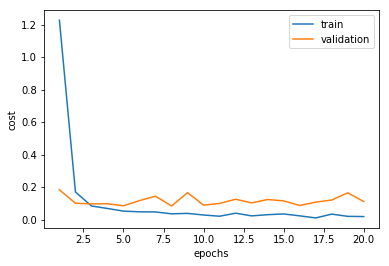

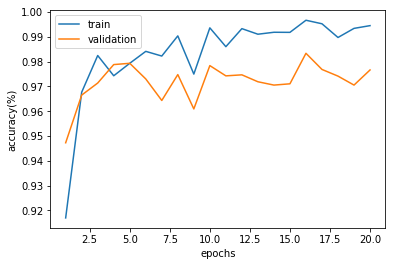

In [46]:
parameters = training(train_images, train_labels, test_images, test_labels)